# Import Libraries and Data

In [1]:
# !pip install wandb spacy gensim wget psutil torch --upgrade -qq

In [2]:
import warnings
import joblib
from pathlib import Path
import gensim
from gensim.models import KeyedVectors
from sklearn.preprocessing import MultiLabelBinarizer

import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

In [3]:
warnings.filterwarnings("ignore")

In [4]:
import sys

In [5]:
sys.path.append(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Custom_Functions")
import custom_functions as cf
import custom_preprocessor as cp
import plot_learning_curve as plc

In [6]:
X_cleaned_comp = r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Datasets\df_stackoverflow_multilabel_X_cleaned.joblib"
y_cleaned_comp = r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Datasets\df_stackoverflow_multilabel_y_cleaned.joblib"
X = joblib.load(X_cleaned_comp)
y = joblib.load(y_cleaned_comp)

In [7]:
print(X[0:3])
print(y[0:3])

['asp query string dropdowni webpage follow control relevance    dropdownlist value hyperlink redirect page call   page cancel button redirect user menu page like user click hyperlink edit page index dropdownlist preserve query string page follow aspx code sure proceed < asp hyperlink      id="lnkedit      navigateurl=\'<% + eval("userid + sure > < /asp hyperlink >   < asp dropdownlist      id="mydropdown      < asp listitems/ > < /asp dropdownlist >   edit clarify m navigateurl query string eval determine user id', 'run javascript code server java code?i want run javascript code server want manipulate result return javascript inside java code', 'linq sql throw exception row find changedhi linq sql get error row find change update table help linq query show error unable figure problem work get permanent solution fix problem twtmob_campainincomedetails_tb incomedetail = datacontext.twtmob_campainincomedetails_tb single(twtincome = > = = tempincome                  decimal temppayout = d

In [8]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [9]:
X_train, X_valid, X_test, y_train, y_valid, y_test = cf.train_valid_test_split(X, y, 0.6, 0.2, 0.2, stratify=False)

X_train: 28456, X_valid: 9485, X_test: 9486, y_train: 28456, y_valid: 9485, y_test: 9486


In [10]:
gnvectors_bin_file = r"H:\My Drive\Datasets_Models\Word_Embeddings\GoogleNews-vectors-negative300.bin"

In [11]:
class GensimVectorizer(BaseEstimator,TransformerMixin):
  np.random.seed(0)
  def __init__(self,pretrained_vectors,unk_norm_init=False):
    # load in pre-trained word vectors
    self.pretrained_vectors= pretrained_vectors
    self.vec_size= self.pretrained_vectors.vector_size
    self.unk_norm_init = unk_norm_init
    self.pretrained_vectors_subset = {}
    self.words_not_in_pretrained = []
    self.count_missing = 0
    self.percent_missing = 0


  def fit(self, X,y=None):
    '''
    Gets the subset of pretrained vectors which are present in vocab
    X :  training sentences
    '''
    counter = Counter()

    for sent in X:
        counter.update(sent.split())
    for token in counter:
        try:
            self.pretrained_vectors_subset[token] = self.pretrained_vectors.get_vector(token, norm=True)
        except:
            self.words_not_in_pretrained.append(token)
    
    ### save so that you can access this after you fit the vectorizer
    self.count_missing = len(self.words_not_in_pretrained )
    self.percent_missing = self.count_missing / len(counter)
    return self
    
  def transform(self,X,y=None):
    X_vector = np.zeros((len(X), self.vec_size))
    
    for i, sent in enumerate(X):
        sent_vector = np.zeros(self.vec_size)
        n=0
        tokens = sent.split()
        for word in tokens:
            if word in self.pretrained_vectors_subset.keys():
                word_vector=self.pretrained_vectors_subset[word]
                sent_vector+= word_vector
                n+= 1
            else:
                if self.unk_norm_init :
                    word_vector = np.random.normal(size=  self.vec_size)
                    sent_vector+= word_vector
                    n+= 1
        if n>0:
            X_vector[i] = sent_vector/n
    return X_vector

In [12]:
X_train_subset1, y_train_subset1 = X_train[:100], y_train[:100]

{'clf__estimator__alpha': 0.1, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.37
0.37
0.4253031101739589


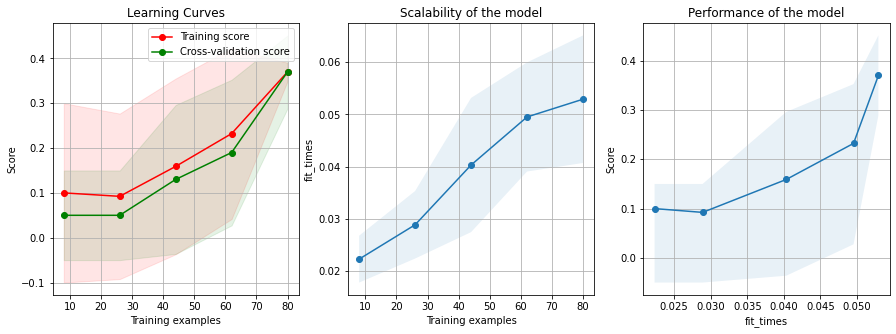

In [13]:
# model1 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=10000)
# pipeline1 = Pipeline([('vectorizer', GensimVectorizer(model1)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=-1)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_trial = GridSearchCV(pipeline1, param_grid, cv=5, return_train_score= True, n_jobs=-1)
# grid_trial.fit(X_train_subset1,y_train_subset1)
# joblib.dump(grid_trial, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
# joblib.dump(grid_trial.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
grid_trial = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
grid_trial_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
print(grid_trial.best_params_)
plc.plot_learning_curve(grid_trial_estimators, 'Learning Curves', X_train_subset1, y_train_subset1, n_jobs=-1)
print(grid_trial.score(X_train_subset1,y_train_subset1))
print(grid_trial.best_score_)
print(grid_trial.score(X_valid,y_valid))

{'clf__estimator__alpha': 0.1, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.37
0.37
0.4253031101739589


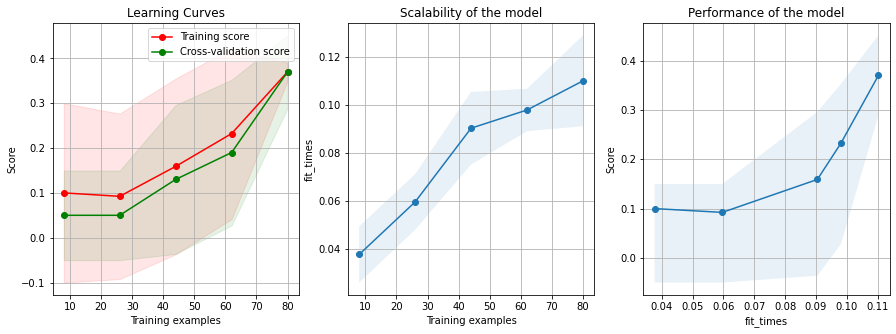

In [14]:
# model1 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=50000)
# pipeline1 = Pipeline([('vectorizer', GensimVectorizer(model1)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_trial = GridSearchCV(pipeline1, param_grid, cv=5, return_train_score= True)
# grid_trial.fit(X_train_subset1,y_train_subset1)
# joblib.dump(grid_trial, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
# joblib.dump(grid_trial.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
grid_trial = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
grid_trial_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
print(grid_trial.best_params_)
plc.plot_learning_curve(grid_trial_estimators, 'Learning Curves', X_train_subset1, y_train_subset1, n_jobs=-1)
print(grid_trial.score(X_train_subset1,y_train_subset1))
print(grid_trial.best_score_)
print(grid_trial.score(X_valid,y_valid))

In [15]:
X_gensim_cleaned = list(map(gensim.utils.simple_preprocess, X))

In [16]:
X_gensim_cleaned_X = []
for lst in X_gensim_cleaned:
    X_gensim_cleaned_X.append(" ".join(lst))

In [17]:
X_train1, X_valid1, X_test1, y_train1, y_valid1, y_test1 = cf.train_valid_test_split(X_gensim_cleaned_X, y, 0.6, 0.2, 0.2, stratify=False)

X_train: 28456, X_valid: 9485, X_test: 9486, y_train: 28456, y_valid: 9485, y_test: 9486


In [18]:
X_train_subset2, y_train_subset2 = X_train1[:100], y_train1[:100]

{'clf__estimator__alpha': 0.1, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.37
0.37
0.4253031101739589


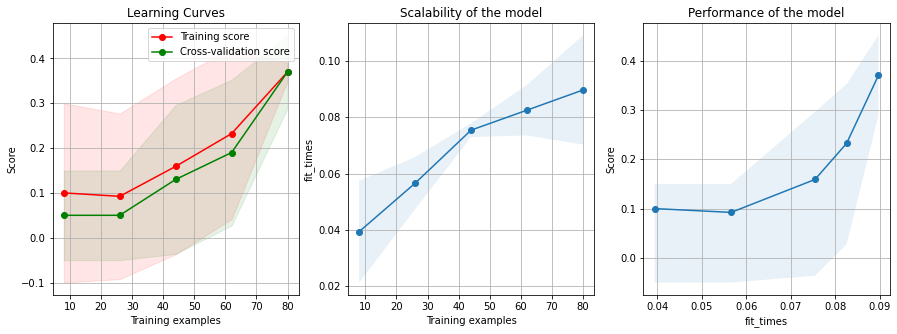

In [19]:
# model1 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=10000)
# pipeline1 = Pipeline([('vectorizer', GensimVectorizer(model1)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=-1)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_trial = GridSearchCV(pipeline1, param_grid, cv=5, return_train_score= True, n_jobs=-1)
# grid_trial.fit(X_train_subset2,y_train_subset2)
# joblib.dump(grid_trial, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
# joblib.dump(grid_trial.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
grid_trial = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
grid_trial_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
print(grid_trial.best_params_)
plc.plot_learning_curve(grid_trial_estimators, 'Learning Curves', X_train_subset2, y_train_subset2, n_jobs=-1)
print(grid_trial.score(X_train_subset2,y_train_subset2))
print(grid_trial.best_score_)
print(grid_trial.score(X_valid1,y_valid1))

{'clf__estimator__alpha': 0.1, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.37
0.37
0.4253031101739589


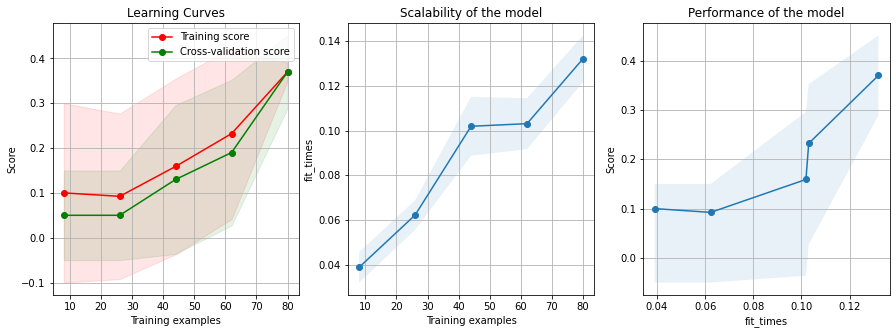

In [20]:
# model1 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=50000)
# pipeline1 = Pipeline([('vectorizer', GensimVectorizer(model1)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_trial = GridSearchCV(pipeline1, param_grid, cv=5, return_train_score= True)
# grid_trial.fit(X_train_subset2,y_train_subset2)
# joblib.dump(grid_trial, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
# joblib.dump(grid_trial.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
grid_trial = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial.joblib")
grid_trial_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_GridTrial_Estimators.joblib")
print(grid_trial.best_params_)
plc.plot_learning_curve(grid_trial_estimators, 'Learning Curves', X_train_subset2, y_train_subset2, n_jobs=-1)
print(grid_trial.score(X_train_subset2,y_train_subset2))
print(grid_trial.best_score_)
print(grid_trial.score(X_valid1,y_valid1))

{'clf__estimator__alpha': 1e-05, 'clf__estimator__loss': 'log', 'clf__estimator__penalty': 'l1'}
0.480039359010402
0.5113861340902337
0.47401159725882974


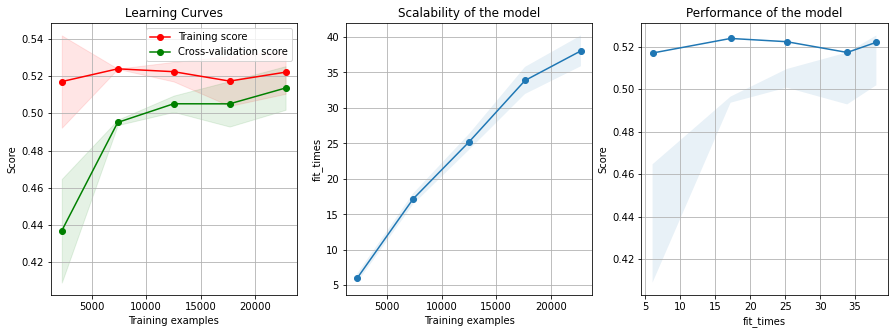

In [21]:
# model1 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=50000)
# pipeline1 = Pipeline([('vectorizer', GensimVectorizer(model1)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=-1)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_1 = GridSearchCV(pipeline1, param_grid, cv=5, return_train_score= True, n_jobs=-1)
# grid_1.fit(X_train,y_train)
# joblib.dump(grid_1, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid1.joblib")
# joblib.dump(grid_1.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid1_Estimators.joblib")
grid_1 = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid1.joblib")
grid_1_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid1_Estimators.joblib")
print(grid_1.best_params_)
plc.plot_learning_curve(grid_1_estimators, 'Learning Curves', X_train, y_train, n_jobs=-1)
print(grid_1.score(X_train,y_train))
print(grid_1.best_score_)
print(grid_1.score(X_valid,y_valid))

{'clf__estimator__alpha': 1e-05, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.5718301939836942
0.5555594802509615
0.5561412756984713


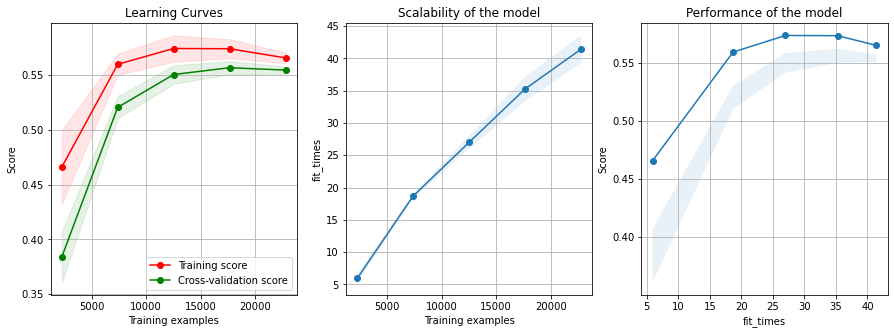

In [22]:
# model2 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=100000)
# pipeline2 = Pipeline([('vectorizer', GensimVectorizer(model2)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=-1)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_2 = GridSearchCV(pipeline2, param_grid, cv=5, return_train_score= True, n_jobs=-1)
# grid_2.fit(X_train,y_train)
# joblib.dump(grid_2, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid2.joblib")
# joblib.dump(grid_2.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid2_Estimators.joblib")
grid_2 = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid2.joblib")
grid_2_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid2_Estimators.joblib")
print(grid_2.best_params_)
plc.plot_learning_curve(grid_2_estimators, 'Learning Curves', X_train, y_train, n_jobs=-1)
print(grid_2.score(X_train,y_train))
print(grid_2.best_score_)
print(grid_2.score(X_valid,y_valid))

{'clf__estimator__alpha': 1e-05, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.6052502108518414
0.5973083154684573
0.5860832894043226


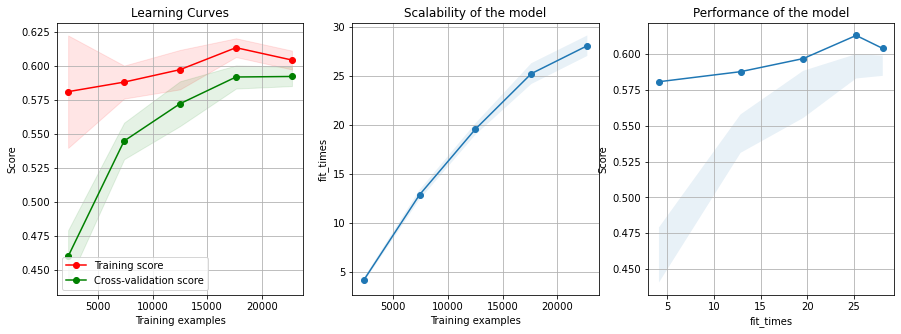

In [25]:
# model3 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=1000000)
# pipeline2 = Pipeline([('vectorizer', GensimVectorizer(model3)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=None)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_3 = GridSearchCV(pipeline2, param_grid, cv=5, return_train_score= True, n_jobs=None)
# grid_3.fit(X_train,y_train)
# joblib.dump(grid_3, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid3.joblib")
# joblib.dump(grid_3.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid3_Estimators.joblib")
grid_3 = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid3.joblib")
grid_3_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid3_Estimators.joblib")
print(grid_3.best_params_)
plc.plot_learning_curve(grid_3_estimators, 'Learning Curves', X_train, y_train, n_jobs=None)
print(grid_3.score(X_train,y_train))
print(grid_3.best_score_)
print(grid_3.score(X_valid,y_valid))

{'clf__estimator__alpha': 1e-05, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l1'}
0.5938290694405398
0.6009276028911278
0.576594623089088


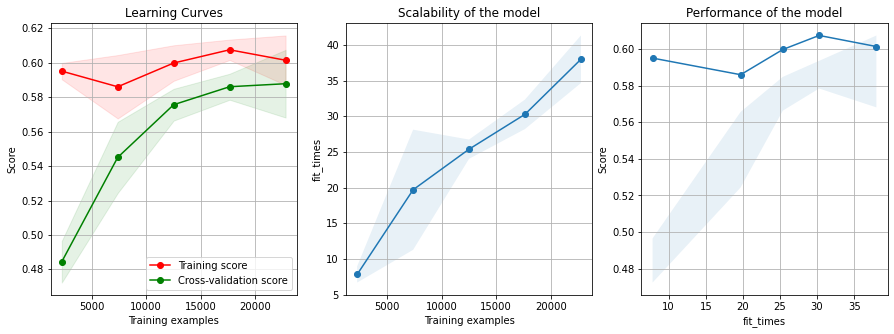

In [26]:
# model4 = KeyedVectors.load_word2vec_format(gnvectors_bin_file,binary=True,limit=2000000)
# pipeline2 = Pipeline([('vectorizer', GensimVectorizer(model4)),
#                      ('clf', OneVsRestClassifier(SGDClassifier(random_state=42, shuffle=True, n_jobs=None)))])
# param_grid = {'clf__estimator__loss':['hinge','log','perceptron'],
#               'clf__estimator__alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
#               'clf__estimator__penalty':['l1','l2','elasticnet']}
# grid_4 = GridSearchCV(pipeline2, param_grid, cv=5, return_train_score= True, n_jobs=None)
# grid_4.fit(X_train,y_train)
# joblib.dump(grid_4, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid4.joblib")
# joblib.dump(grid_4.best_estimator_, r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid4_Estimators.joblib")
grid_4 = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid4.joblib")
grid_4_estimators = joblib.load(r"C:\Users\vicky\OneDrive - The University of Texas at Dallas\Documents\Vikash\Courses\BUAN 6342 - Applied Natural Language Processing\Assignments\Assignment 6\Datasets_Models\Models\Task4_Grid4_Estimators.joblib")
print(grid_4.best_params_)
plc.plot_learning_curve(grid_4_estimators, 'Learning Curves', X_train, y_train, n_jobs=None)
print(grid_4.score(X_train,y_train))
print(grid_4.best_score_)
print(grid_4.score(X_valid,y_valid))

In [30]:
y_predicted_test = grid_4.predict(X_test)
y_predicted_valid = grid_4.predict(X_valid)
y_predicted_train = grid_4.predict(X_train)

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score_train = f1_score(y_train, y_predicted_train, average = 'micro')
f1_score_valid = f1_score(y_valid, y_predicted_valid, average = 'micro')
f1_score_test = f1_score(y_test, y_predicted_test, average = 'micro')

In [33]:
# Print Accuracy based on saved Model
print('f1_score_train', f1_score_train)
print('f1_score_valid', f1_score_valid)
print('f1_score_test', f1_score_test)

f1_score_train 0.8177195244234351
f1_score_valid 0.8048314636967692
f1_score_test 0.7999353848639044
